<a href="https://colab.research.google.com/github/seanjhannon/pitch-prediction/blob/main/pitch_prediciton_proof_of_concept_kershaw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Data Loading

In [2]:
pip install pybaseball

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


# pybaseball imports
from pybaseball import  playerid_lookup
from pybaseball import  statcast_pitcher
from pybaseball import statcast_batter
from pybaseball import statcast_running
from pybaseball import playerid_reverse_lookup
from pybaseball import batting_stats
from pybaseball import get_splits
from pybaseball import team_game_logs

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix



In [4]:
def get_pitches(
    fname: str,
    lname: str,
):
  """
  Returns all pitches for a specified pitcher between the start of hhis career (or 2008) and today.

  Params
    fname (string): Pitcher's first name.
    lname (string): Pitcher's last name.

  Returns
    pitches (pandas DataFrame): DataFrame of statcast data for all pitches in the player's career.
  """
  # Search for player 'lookup' - returns their metadata
  player_lookup = playerid_lookup(lname, fname)

  if len(player_lookup) != 1:
    print(f'Player Lookup returned {len(player_lookup)} results. Please double-check inputs and try again.')
    return None

  # Collect the player's lmbam_id and start and end of his career
  player_id = player_lookup['key_mlbam'][0]
  player_career_start = int(player_lookup['mlb_played_first'][0])
  player_career_end = int(player_lookup['mlb_played_last'][0])

  # Separately define the start and end dates for our pitching stats query and format them as str
  pitching_start = dt.date(player_career_start, 1, 1).strftime('%Y-%m-%d') # Jan 1 of their first career year
  pitching_end = dt.date.today().strftime('%Y-%m-%d') # Ok to overshoot the end date, maybe revisit this later

  pitches = statcast_pitcher(start_dt=pitching_start,
                             end_dt=pitching_end,
                             player_id=player_id)

  if len(pitches) == 0:
    print(f'No pitches found for {fname} {lname}')

  return pitches

In [5]:
# Pull data for a single pitcher

kershaw_lookup = get_pitches('clayton', 'kershaw')

Gathering player lookup table. This may take a moment.
Gathering Player Data


/usr/local/lib/python3.10/dist-packages/pybaseball/utils.py:295: DtypeWarning: Columns (43,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(data.text))


In [6]:
kershaw_lookup.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [7]:
kershaw_lookup.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,FF,2013-10-18,93.0,1.58,6.31,"Kershaw, Clayton",571431,477132,double,hit_into_play,...,0,0,5,5,0,NaN,NaN,NaN,0.018,1.323
1,FF,2013-10-18,93.0,1.50,6.34,"Kershaw, Clayton",571431,477132,NaN,foul,...,0,0,4,4,0,NaN,NaN,NaN,0.000,-0.049
2,FF,2013-10-18,92.9,1.37,6.39,"Kershaw, Clayton",501896,477132,single,hit_into_play,...,0,0,4,4,0,NaN,NaN,NaN,0.013,0.618
3,FF,2013-10-18,92.3,1.35,6.36,"Kershaw, Clayton",501896,477132,NaN,ball,...,0,0,4,4,0,NaN,NaN,NaN,0.000,0.037
4,FF,2013-10-18,92.6,1.24,6.34,"Kershaw, Clayton",501896,477132,NaN,foul,...,0,0,4,4,0,NaN,NaN,NaN,0.000,-0.048


In [8]:
# Collection of colnames marked as deprecated in thhe library's documentation

deprecated_cols = [
    'spir_dir',
    'spin_rate_deprecated',
    'break_angle_deprecated',
    'break_length_deprecated',
    'tfs_deprecated',
    'tfs_zulu_deprecated',
    'umpire'
]

## Exploratory Data Analysis

In [9]:
# What does the description column look like?
kershaw_lookup['description'].unique()

array(['hit_into_play', 'foul', 'ball', 'swinging_strike',
       'called_strike', 'intent_ball', 'blocked_ball',
       'swinging_strike_blocked', 'foul_tip', 'foul_bunt', 'hit_by_pitch',
       'missed_bunt', 'bunt_foul_tip'], dtype=object)

## Preprocessing

In [ ]:
# Pitch Type Mapping


In [10]:
def pitch_id(row):
  """
  Creates a unique id for each pitch by combining game, batter, at bat, and pitch number. Since pitch number is thhe last digit(s), the id is sortable.
  """
  game_id = row['game_pk']
  batter_id = row['batter']
  at_bat = row['at_bat_number']
  pitch_number = row['pitch_number']
  args = [game_id, batter_id, at_bat, pitch_number]
  id = ''.join(str(arg) for arg in args)
  return int(id)

**a note on pre-vs-post-pitch**

The presence of pre-pitch stats means this data needs to be handled carefully. To avoid data leakage, when predicting the label of a row of data, all data in that row must be 'pre-pitch'. This can be ensured in one of these mutually exclusive ways:
1. Use only the provided 'pre-pitch' data, stored in `pre_pitch_cols`
2. Use the full set of data for the preceding pitch, minus its `pre_pitch_cols` data. This can be done by a lookup from the pitch_id that I created, where the prevoious pitch has an id 1 lower than the pitch we are predicting (unless it is the first pitch of the game)

In [11]:
# Collection of features a person sitting behind home plate would know before the pitch
pre_pitch_cols = [
    #'ID',
    'pitch_type', # TARGET
    'game_date',
    'player_name', # Will always be the selected pitcher
    'batter',
    'pitcher', # Will always be the selected pitcher
    'game_type',
    'stand',
    'p_throws',
    'home_team',
    'away_team',
    'balls',
    'strikes',
    'game_year',
    'on_3b',
    'on_2b',
    'on_1b',
    'outs_when_up',
    'inning',
    'inning_topbot',
    #'fielder_2', # all fielder info ignored
    'at_bat_number',
    'home_score',
    'away_score',
    'bat_score',
    'fld_score',
    'if_fielding_alignment',
    'of_fielding_alignment'
]
post_pitch_cols = [] # everything else

# Feature Engineering
This is done on the data to create feaures that shouldbe useful for all types of models.

In [51]:
pitch_type_mapping = {'CH': 0, 'CU': 1, 'FA': 2, 'FF': 3, 'FS': 4, 'IN': 5, 'SI': 6, 'SL': 7}

In [12]:
# Replace 'batter' with batting average
# Replace the features for runners on base with each runner's sbp
# Create a feature to indicte if pitcher's team is home or away
# Create opp_team feature

### Encoding `batter` from player_id to batting average

In [13]:
def get_avg(player_id: str):
  """
  Returns a player's career Batting Average.

  Params
    player_id (str): The mlbam key given in the pitching statcast.

  Returns
    avg (float): The player's career batting average.
  """
  player_lookup = playerid_reverse_lookup([int(player_id)]) # ID must be cast to an int...
  bbref_key = player_lookup['key_bbref'][0]
  player_splits = get_splits(bbref_key)
  avg = player_splits['BA'][0]
  return avg

In [14]:
class BatterEncoder(BaseEstimator, TransformerMixin):
  # Creates column batter_avg, drops 'batter'

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X['batter'] = X['batter'].apply(get_avg)
    #X = X.drop('batter')
    return X

### Encoding runner Stolen Base Percentage from runner features

In [15]:
def binarize_runner(player_id: str):
  """
  Returns 1 if there is a player on base, otherwise 0.

  Params
    player_id (str): The mlbam key given in the pitching statcast.

  Returns
    1 or  0.
  """
  if np.isnan(player_id): # if it's a NaN, leave it alone
    return 0
  else:
    return 1


In [16]:
class RunnerEncoderBinary(BaseEstimator, TransformerMixin):
  # Works in-place, does not create additional columns
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X['on_3b'] = X['on_3b'].apply(binarize_runner)
    X['on_2b'] = X['on_2b'].apply(binarize_runner)
    X['on_1b'] = X['on_1b'].apply(binarize_runner)
    #X = X.drop(['on_3b','on_2b', 'on_1b',], axis = 1)
    return X

### Encoding Home / Away and creating a feature to indicate opposing team

In [17]:
def get_opp(row):
  at_home = False
  top_bot = row['inning_topbot']
  if top_bot == 'Bot':
    at_home = True
  if at_home:
    return row['home_team']
  else:
    return row['away_team']


In [18]:
class OppTeamEncoder(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X['opp_team'] = X.apply(get_opp, axis = 1)
    X = X.drop(['home_team','away_team', 'inning_topbot'], axis = 1)
    return X

# Initial Model Testing

In [35]:
target = 'pitch_type'
test_sample = kershaw_lookup[pre_pitch_cols]
df = test_sample.dropna(subset=[target])

## Baseline model - always predict four-seam fastball
To get a baseline to compare our models to, we first create a naive model that always predicts a four-seam fastball - the most common pitch category in baseball

In [36]:
# Baseline model that predicts a four seam fastball for every pitch
def guess_ff(X):
  """
  Naive model that predicts a four seam fastball for every pitch

  Params
    X(pandas DataFrame): Transformed feature matrix of a pitcher's pitches.

  Returns
    Array of predicitons.
  """
  pred_len = len(X)
  preds = ['FF'] * pred_len
  return preds


In [45]:
y_test.unique()

array(['FF', 'SL', 'CU', 'CH', 'SI', 'IN', 'FS'], dtype=object)

Classification Report:
              precision    recall  f1-score   support

          CH       0.00      0.00      0.00       163
          CU       0.00      0.00      0.00      1272
          FF       0.54      1.00      0.70      4750
          FS       0.00      0.00      0.00         1
          IN       0.00      0.00      0.00        14
          SI       0.00      0.00      0.00        27
          SL       0.00      0.00      0.00      2595

    accuracy                           0.54      8822
   macro avg       0.08      0.14      0.10      8822
weighted avg       0.29      0.54      0.38      8822



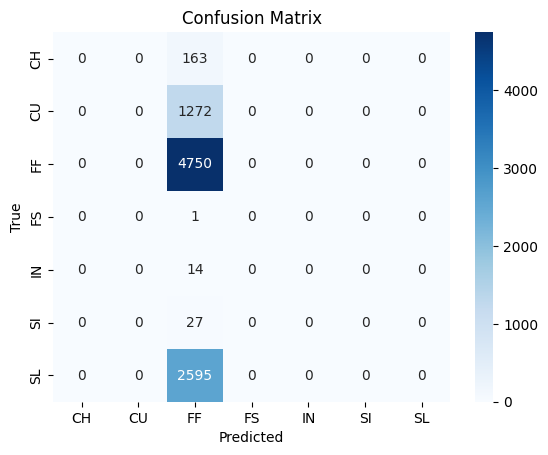

In [55]:
# Get baseline results
X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis=1), df[target], test_size=0.2, random_state=42)

baseline_preds = guess_ff(X_test)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, baseline_preds, zero_division=0))


pitch_lables = ['CH', 'CU', 'FF', 'FS', 'IN', 'SI', 'SL']

conf_matrix = confusion_matrix(y_test, baseline_preds)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g',
            xticklabels=pitch_lables, yticklabels=pitch_lables

            )
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Testing an XGBoost Model on basic pre-pitch Data

In [21]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable with LabelEncoder
label_encoder = LabelEncoder()
df[target] = label_encoder.fit_transform(df[target])


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis=1), df[target], test_size=0.2, random_state=42)


# Define numeric and categorical columns
num_cols = [
    'balls',
    'strikes',
    'game_year',
    'outs_when_up',
    'inning',
    'at_bat_number',
    'bat_score',
    'fld_score',
]

cat_cols = [
    'game_type',
    'stand',
    'p_throws',
    'inning_topbot',
    'if_fielding_alignment',
    'of_fielding_alignment'
]


# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])



# Create pipeline with DropNaNRows transformer
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(objective='multi:softmax', num_class=len(df[target].unique())))
])

# Fit the model
pipeline.fit(df.drop([target], axis=1), df[target])

# Make predictions
y_pred = pipeline.predict(X_test)

<ipython-input-21-324e9cf4a242>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = label_encoder.fit_transform(df[target])


In [22]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.06      0.11       163
           1       0.52      0.32      0.40      1272
           3       0.68      0.83      0.75      4750
           4       1.00      1.00      1.00         1
           5       1.00      0.86      0.92        14
           6       1.00      0.48      0.65        27
           7       0.58      0.49      0.53      2595

    accuracy                           0.64      8822
   macro avg       0.81      0.58      0.62      8822
weighted avg       0.63      0.64      0.62      8822



<Axes: ylabel='Feature'>

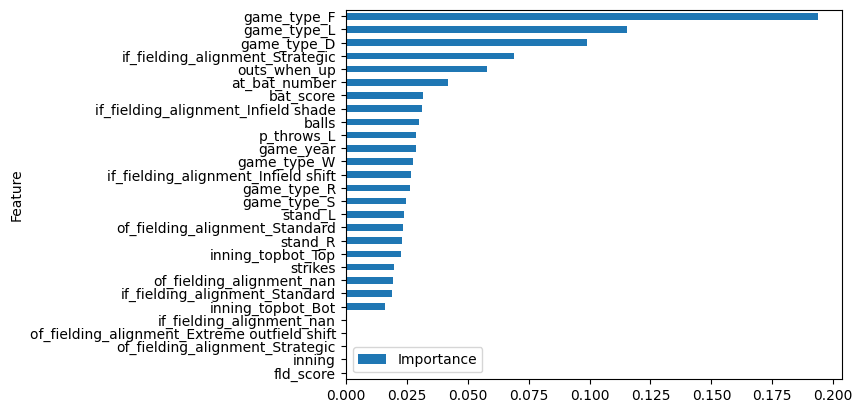

In [30]:
# Calculate feature importances
feature_importances = pipeline.named_steps['classifier'].feature_importances_
feature_importances
# # Plot feature importances
# plt.barh(range(len(feature_importances)), feature_importances, tick_label=num_cols + pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols))
# plt.xlabel('Feature Importance')
# plt.title('Feature Importances')

feature_names = []

# Retrieve categorical feature names after one-hot encoding
cat_feature_names = pipeline.named_steps['preprocessor']\
                             .named_transformers_['cat']\
                             .named_steps['onehot']\
                             .get_feature_names_out()

# Append categorical feature names to the list of feature names
feature_names.extend(cat_feature_names)

# Append numeric feature names
numeric_feature_names = num_cols  # numeric feature names
feature_names.extend(numeric_feature_names)

feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance')
feature_df.plot.barh(x='Feature')

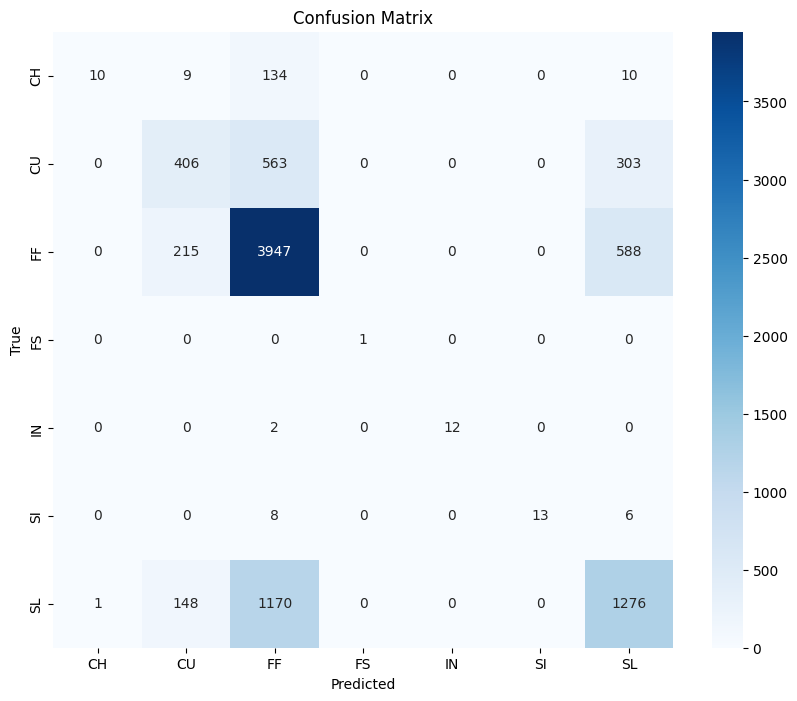

In [31]:
# Create a legible confusion matrix
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
swapped_map = {v: k for k, v in le_name_mapping.items()}
vfunc = np.vectorize(lambda x: swapped_map.get(x, x))

# Apply the mapping to the preds
y_pred_mapped = vfunc(y_pred)
# apply the mapping to the test set
y_test_mapped = y_test.map(swapped_map)

le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
conf_matrix = confusion_matrix(y_test_mapped, y_pred_mapped)
common_labels = set(y_test).intersection(y_pred)
mapped_set = {swapped_map.get(value, value) for value in common_labels}

# Plot confusion matrix using seaborn heatmap with common labels
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g',
            xticklabels=sorted(mapped_set), yticklabels=sorted(mapped_set)
            )
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Analysis
Overall, we see an improvement in every performance metric. This suggests that, from the data we have, we can predict a pitcher's next pitch more accurately than by guessing.

**Next Steps**
With a proof of concept for Clayton Kershaw's pitching, Next steps include
1. Enhance pre-pitch features
2. Generalize steps taken above into a pipeline, test it on other pitchers
3. Explore time-series modeling
